# Example Notebook

This notebook describes an easy 2d problem in parallel.

The difference with the notebook example2dNormalParallel.ipynb is that I make the evaluation of simulated moments longer by increasing the number of draws from the multivariate normal.

## Results

I run this notebook on AWS EC2, using the instance `c5.18xlarge`

### runntime 

* serial : 570.9347720146179 seconds
* 4 workers: 154.74501013755798 seconds
* 16 workers: 152.819402217865 seconds
* 71 workers : 154.44332098960876 seconds


In [1]:
addprocs(71)

71-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
  ⋮
 61
 62
 63
 64
 65
 66
 67
 68
 69
 70
 71
 72

In [2]:
@everywhere using SMM
@everywhere using Distributions
@everywhere using DataStructures

## Step 1: Initializing a SMMProblem

Let's initialize a SMMProblem. Options are to be passsed via `SMMOptions()`. Here we specify the we want to run the optimizer for 1000 iterations and that we want to save the optimization every 1000 steps (that is, only once; when the estimation is complete). 

We set the optimizer to `:dxnes` because it supports parallel estimation. See the page https://github.com/robertfeldt/BlackBoxOptim.jl to see which optimizer supports parallelization. 

In [3]:
myProblem = SMMProblem(options = SMMOptions(maxFuncEvals=1000, saveSteps = 1000, bbOptimizer = :dxnes));

## Options

[TOBECOMPLETED]

## Step 2: Set emprical moments

Empirical moments can be loaded from a .csv file using the function `read_empirical_moments(path::String)`.
The .csv file should should contain at least three columns:
* `name`: empirical moments' names
* `value`: empirical moments' values
* `weights`: weight associated with each parameter value

If, for each moment, `weight` is set to be equal to `value`, the objective funtion to be minimized will be 
the mean percentage deviation of simulated moments from their empirical counterparts. 

In [4]:
dictEmpiricalMoments = read_empirical_moments(joinpath(Pkg.dir("SMM"), "test/empiricalMomentsTest2d.csv"))

INFO: 2 moment(s) found.


DataStructures.OrderedDict{String,Array{Float64,1}} with 2 entries:
  "mean1" => [1.0, 1.0]
  "mean2" => [-1.0, -1.0]

Alternatively, one may construct "manually" empirically directly from Julia:

In [5]:
dictEmpiricalMoments = OrderedDict{String,Array{Float64,1}}()
dictEmpiricalMoments["mean1"] = [1.0; 1.0]
dictEmpiricalMoments["mean2"] = [-1.0; -1.0]

2-element Array{Float64,1}:
 -1.0
 -1.0

One has to let SMM.jl know that we are going to use the empirical moments stored in `dictEmpiricalMoments`.
Use the function `set_empirical_moments!()` for that purpose:

In [6]:
set_empirical_moments!(myProblem, dictEmpiricalMoments)

DataStructures.OrderedDict{String,Array{Float64,1}} with 2 entries:
  "mean1" => [1.0, 1.0]
  "mean2" => [-1.0, -1.0]

## Step 3. Set priors

Priors for parameter values can be loaded from a .csv file using the function `read_priors(path::String)`. The .csv file should contain at least four columns:
* `name` : name for each parameter
* `value` : initial guess
* `lower_bound` : lower bound for this parameter
* `upper_bound`: upper bound for this parameter

In [7]:
read_priors(joinpath(Pkg.dir("SMM"), "test/priorsTest2d.csv"))

INFO: 2 prior(s) values found


DataStructures.OrderedDict{String,Array{Float64,1}} with 2 entries:
  "mu1" => [0.5, -5.0, 5.0]
  "mu2" => [0.1, -5.0, 5.0]

It is also possible to specify priors manually:

In [8]:
dictPriors = OrderedDict{String,Array{Float64,1}}()
dictPriors["mu1"] = [0., -5.0, 5.0]
dictPriors["mu2"] = [0., -5.0, 5.0]

3-element Array{Float64,1}:
  0.0
 -5.0
  5.0

One has to attach priors values the `SMMProblem` we are going to use.
This is achieved using the function  `set_priors!()`

In [9]:
set_priors!(myProblem, dictPriors)

DataStructures.OrderedDict{String,Array{Float64,1}} with 2 entries:
  "mu1" => [0.0, -5.0, 5.0]
  "mu2" => [0.0, -5.0, 5.0]

## Step 3: Specifying the function that generate simulated moments using parameter values

When running in parallel, this function has now three constraints:
* it should take as an argument a vector (the vector of parameters)
* it should return an OrderedDict containing the same moments as the ones contained in the OrderedDict 
containing empirical moments (`dictEmpiricalMoments`)
* it should be preceded by `@everywhere`

In this example, we simulate draws from a mutlivariate normal with unit variance:

In [10]:
@everywhere function functionTest2d(x)

    d = MvNormal([x[1]; x[2]], eye(2))
    output = OrderedDict{String,Float64}()

    draws = rand(d, 10000000)
    output["mean1"] = mean(draws[1,:])
    output["mean2"] = mean(draws[2,:])

    return output
end

In [11]:
@time functionTest2d([0.; 0.])

  0.856839 seconds (152.69 k allocations: 313.035 MiB, 27.64% gc time)


DataStructures.OrderedDict{String,Float64} with 2 entries:
  "mean1" => -3.28192e-5
  "mean2" => 0.000398531

Let's attach the function `functionTest2d(x)` to our SMMProblem using the function `set_simulate_empirical_moments!()`

In [12]:
set_simulate_empirical_moments!(myProblem, functionTest2d)

functionTest2d (generic function with 1 method)

## Step 4. Constructing the objective function

Having completed steps 1 - 3, it is now time to build the function that the solver will be 
minimizing. This is achieved with the function `construct_objective_function!`

In [13]:
# Construct the objective function using: 
#* the function: parameter -> simulated moments
#* emprical moments values
#* emprical moments weights
    
construct_objective_function!(myProblem)

(::objective_function_percent) (generic function with 1 method)

## Step 5. Running the optimization

It is now time to call the minimization algorithm using the function `smmoptimize!()`.
The optimization is done by `BlackBoxOptim.jl`. By default, the optimizer is `:adaptive_de_rand_1_bin_radiuslimited`.

In [14]:
# Run the optimization
# This function first modifies t.bbSetup
# and then modifies t.bbResults
@time smmoptimize!(myProblem, verbose = true)

INFO: 71 worker(s) detected
INFO: Starting optimization in parallel


-------------------------------------
Batch 1.0 / 1.0
------------------------------------- 

Starting optimization with optimizer BlackBoxOptim.XNESOpt{Float64,BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
sigma=1.0 |trace(ln_B)|=0.0
1.38 secs, 4 evals, 1 steps, fitness=5.292639312
sigma=0.973258266541932 |trace(ln_B)|=2.7755575615628914e-17
2.03 secs, 8 evals, 2 steps, fitness=4.308712105
sigma=0.9949048636247245 |trace(ln_B)|=2.7755575615628914e-17
2.67 secs, 12 evals, 3 steps, fitness=4.308712105
sigma=0.9695788117771211 |trace(ln_B)|=2.7755575615628914e-17
3.30 secs, 16 evals, 4 steps, fitness=0.924361460
sigma=0.9981746325342928 |trace(ln_B)|=2.7755575615628914e-17
3.97 secs, 20 evals, 5 steps, fitness=0.483880492
sigma=1.0143147792731884 |trace(ln_B)|=2.7755575615628914e-17
4.64 secs, 24 evals, 6 steps, fitness=0.483880492
sigma=0.9914147319980863 |trace(ln_B)|=5.551115123125783e-17
5.27 secs, 28 evals, 7 steps, fitness=0.081326043


44.94 secs, 284 evals, 71 steps, fitness=0.001476576
sigma=0.22826975111664935 |trace(ln_B)|=4.996003610813204e-16
45.57 secs, 288 evals, 72 steps, fitness=0.000335384
sigma=0.2349112036944117 |trace(ln_B)|=4.996003610813204e-16
46.19 secs, 292 evals, 73 steps, fitness=0.000335384
sigma=0.21743522826039127 |trace(ln_B)|=4.440892098500626e-16
46.78 secs, 296 evals, 74 steps, fitness=0.000335384
sigma=0.21667882069679012 |trace(ln_B)|=4.440892098500626e-16
47.43 secs, 300 evals, 75 steps, fitness=0.000335384
sigma=0.21168412170907885 |trace(ln_B)|=4.440892098500626e-16
48.01 secs, 304 evals, 76 steps, fitness=0.000335384
sigma=0.2108313383124977 |trace(ln_B)|=4.440892098500626e-16
48.59 secs, 308 evals, 77 steps, fitness=0.000335384
sigma=0.20068659722252966 |trace(ln_B)|=4.440892098500626e-16
49.26 secs, 312 evals, 78 steps, fitness=0.000335384
sigma=0.1849819191937335 |trace(ln_B)|=5.551115123125783e-16
49.85 secs, 316 evals, 79 steps, fitness=0.000335384
sigma=0.187438224405794 |trace

88.33 secs, 568 evals, 142 steps, fitness=0.000013673
sigma=0.044761159962501705 |trace(ln_B)|=2.498001805406602e-16
88.88 secs, 572 evals, 143 steps, fitness=0.000013673
sigma=0.043787507969337475 |trace(ln_B)|=2.7755575615628914e-16
89.46 secs, 576 evals, 144 steps, fitness=0.000013673
sigma=0.0429366705836079 |trace(ln_B)|=2.7755575615628914e-16
90.04 secs, 580 evals, 145 steps, fitness=0.000013673
sigma=0.04203030328718659 |trace(ln_B)|=3.0531133177191805e-16
90.70 secs, 584 evals, 146 steps, fitness=0.000013673
sigma=0.041103202424603184 |trace(ln_B)|=3.3306690738754696e-16
91.35 secs, 588 evals, 147 steps, fitness=0.000013673
sigma=0.03753404031599326 |trace(ln_B)|=4.440892098500626e-16
91.94 secs, 592 evals, 148 steps, fitness=0.000013673
sigma=0.03705264599936943 |trace(ln_B)|=4.440892098500626e-16
92.62 secs, 596 evals, 149 steps, fitness=0.000013673
sigma=0.03666096097133155 |trace(ln_B)|=4.163336342344337e-16
93.20 secs, 600 evals, 150 steps, fitness=0.000013673
sigma=0.0362

131.07 secs, 848 evals, 212 steps, fitness=0.000005591
sigma=0.007956020414138882 |trace(ln_B)|=7.771561172376096e-16
131.68 secs, 852 evals, 213 steps, fitness=0.000005591
sigma=0.008149042972244301 |trace(ln_B)|=7.216449660063518e-16
132.32 secs, 856 evals, 214 steps, fitness=0.000005591
sigma=0.007520229986092499 |trace(ln_B)|=6.938893903907228e-16
132.89 secs, 860 evals, 215 steps, fitness=0.000005591
sigma=0.007402535758068457 |trace(ln_B)|=7.216449660063518e-16
133.54 secs, 864 evals, 216 steps, fitness=0.000000606
sigma=0.007099601706373302 |trace(ln_B)|=7.771561172376096e-16
134.18 secs, 868 evals, 217 steps, fitness=0.000000606
sigma=0.007105284837348068 |trace(ln_B)|=7.771561172376096e-16
134.73 secs, 872 evals, 218 steps, fitness=0.000000606
sigma=0.006833496836634788 |trace(ln_B)|=7.91033905045424e-16
135.37 secs, 876 evals, 219 steps, fitness=0.000000096
sigma=0.00674015317417614 |trace(ln_B)|=7.91033905045424e-16
136.00 secs, 880 evals, 220 steps, fitness=0.000000096
sigm

INFO: Best Value: [0.999896, -1.0008]
INFO: Best Fitness: 9.60107440082645e-8


207.020198 seconds (10.08 M allocations: 901.771 MiB, 0.23% gc time)


INFO: Saving optimisation to disk
INFO: Done.


(Any[9.60107e-8], Any[[0.999896, -1.0008]])

## Step 6. Analysing Results

### A. Point estimates

The parameter value that minimizes the distance between empirical and simulated moments can be accessed using 
the function `smm_minimizer` 

In [15]:
minimizer = smm_minimizer(myProblem)
println(minimizer[1])
println(minimizer[2])

0.9998961259529692
-1.0008042783298716


### B. Standard errors

[WORKINPROGRESS]

### C. Slices

Slices of the objective function around a certain parameter value using the function `smm_slices(sMMProblem::SMMProblem, paramValues::Vector, nbPoints::Int64; showPlots::Bool = true)`

INFO: slicing along mu1


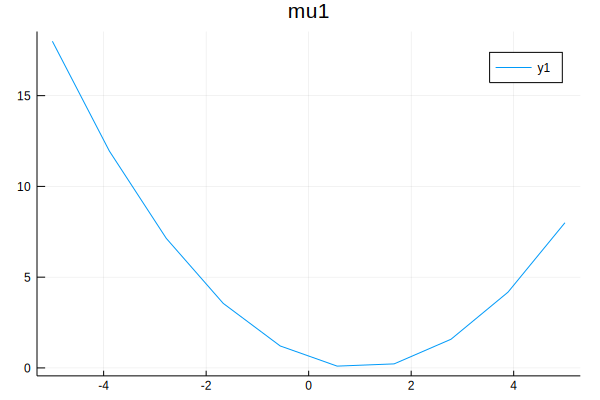

INFO: slicing along mu2


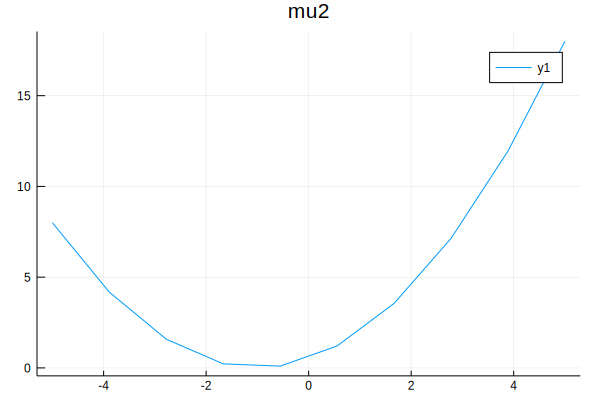

 18.421054 seconds (12.72 M allocations: 650.406 MiB, 2.39% gc time)


2-element Array{Any,1}:
 Plot{Plots.GRBackend() n=1}
 Plot{Plots.GRBackend() n=1}

In [16]:
Plots.gr()
@time listPlots = smm_slices(myProblem, minimizer, 10)

You can combine the several plots created into a single one:

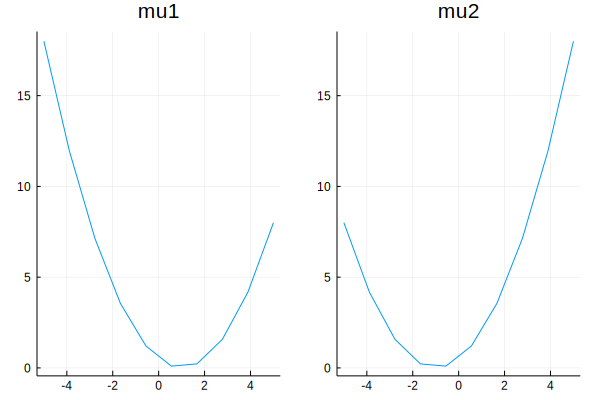

In [17]:
Plots.plot(listPlots[1], listPlots[2], leg = false)